In [40]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
import string

In [2]:
Tweet = pd.read_csv("input/Tweets.csv")
print(Tweet.shape)
print(Tweet.airline_sentiment.unique())
print(Tweet.name.nunique())

(14640, 15)
['neutral' 'positive' 'negative']
7701


We have 14640 tweets from 7701 users. We need to use the tweet text to classify positive, negative, and neutral tweets.

In [3]:
Tweet.isnull().sum()/Tweet.shape[0]

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [4]:
del Tweet["airline_sentiment_gold"]
del Tweet["negativereason_gold"]
del Tweet["tweet_coord"]

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


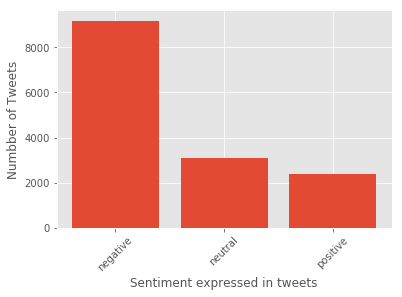

In [5]:
Index = [1,2,3]
print(Tweet.airline_sentiment.value_counts())
plt.bar(Index,Tweet.airline_sentiment.value_counts())
plt.xticks(Index,['negative','neutral','positive'],rotation=45)
plt.ylabel('Numbber of Tweets')
plt.xlabel('Sentiment expressed in tweets')


About 60% of the reported sentiments were negative.

In [6]:
df=Tweet.groupby(["airline","airline_sentiment"]).size().unstack()
print(df)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


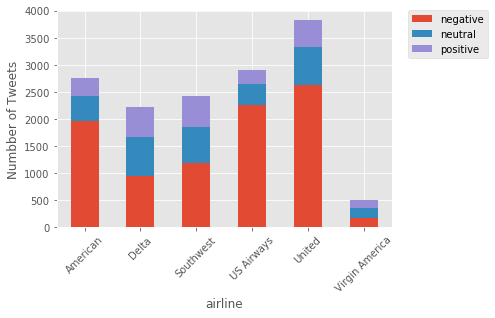

In [7]:
ax=df.plot.bar(stacked=True)
plt.ylabel('Numbber of Tweets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

I plotted how sentiments varies across different airlines. United had the most tweets with negative sentiment

airline_sentiment  negative   neutral  positive
airline                                        
American           0.710402  0.167814  0.121783
Delta              0.429793  0.325383  0.244824
Southwest          0.490083  0.274380  0.235537
US Airways         0.776862  0.130793  0.092345
United             0.688906  0.182365  0.128728
Virgin America     0.359127  0.339286  0.301587


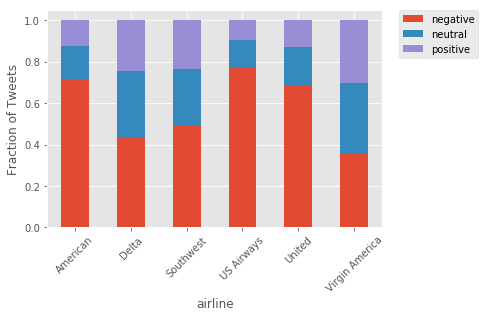

In [8]:
df=Tweet.groupby(["airline","airline_sentiment"]).size().unstack()
df=df.div(df.sum(axis=1),axis='index')
print(df)
ax=df.plot.bar(stacked=True)
plt.ylabel('Fraction of Tweets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Normalized sentiment by airline
I next plotted how the relative number of the individual sentiments varies across different airlines. United had the most negative tweets, however, it also has the most tweets. The number of tweets about an airline may be correlated to the number of planes the airline operates. I therefore divided the tweets with individual sentiments by total number of tweets. It appears that US Airways has relatively higher tweets with negative sentiments. I investigated the reason for negative sentiments.

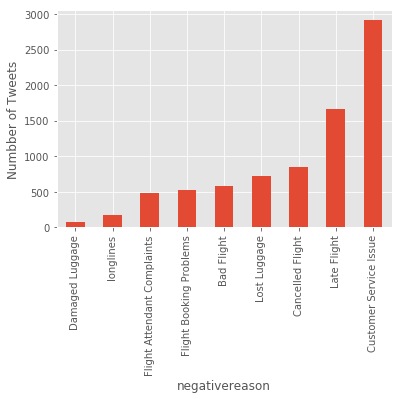

In [9]:
Tweet_negative=Tweet[(Tweet.airline_sentiment=="negative") & (Tweet.negativereason !="Can't Tell")]
df=Tweet_negative.groupby(["negativereason"]).size().sort_values()
df.plot.bar()
plt.ylabel('Numbber of Tweets')

I plotted the reason for negative comment reported in the tweets. I excluded data where the reason was given as 'can't tell'. The plot shows that the most common reason for negative sentiment was customer service issue, followed by late fight and canceled flights.

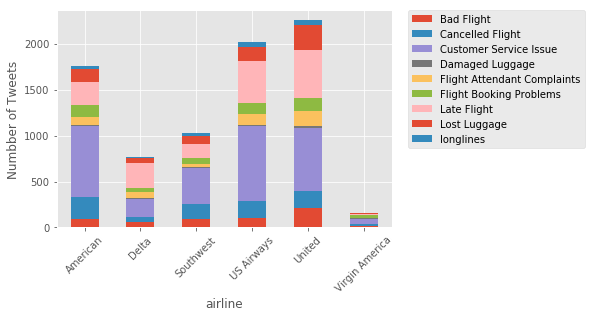

In [10]:
df=Tweet_negative.groupby(["airline","negativereason"]).size().unstack()
ax=df.plot.bar(stacked=True)
plt.ylabel('Numbber of Tweets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


I next grouped the reason for negative comments by airline, and plot them in stacked bar graphs. United had most number of negative tweets, however, the relative distribution of negative comments was different for different airlines. Southwest had the most number of negative comments due to customer service issues. I next normalize the reason for negative comment by total number of negative tweets for each airline.

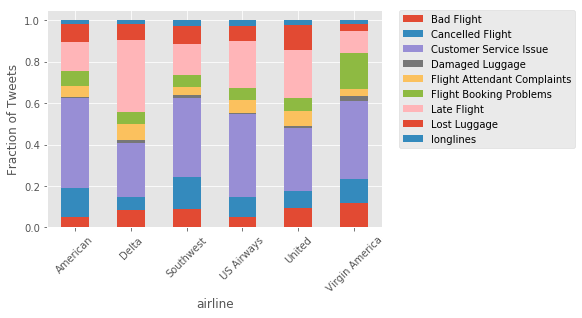

In [11]:
df=Tweet_negative.groupby(["airline","negativereason"]).size().unstack()
df=df.div(df.sum(axis=1),axis='index')
ax=df.plot.bar(stacked=True)
plt.ylabel('Fraction of Tweets')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

After normalizing, the contribution of negative tweets due to poorer customer service is higher (more than 50%) for Virgin America, Delta and Southwest. US Airways had the least fractions of negative tweets due to customer service issues. US airways and American Airlines have as much complaints due to customer service as due to lost luggage.

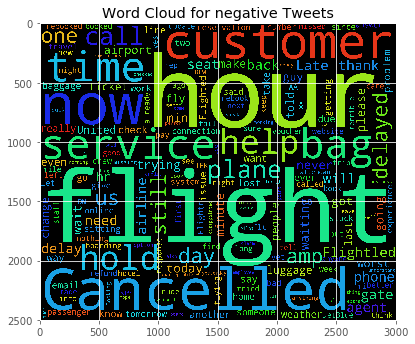

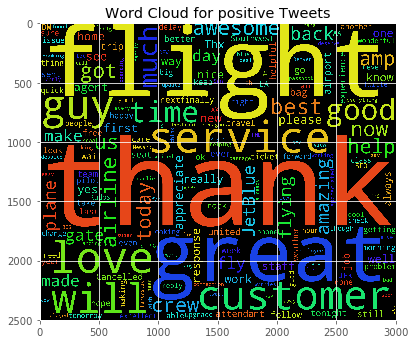

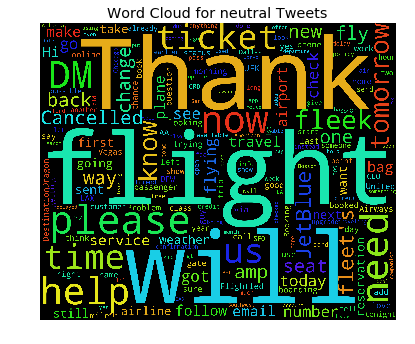

In [12]:
def wordcloud_show(df):
    words = ' '.join(df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=3000,
                          height=2500
                         ).generate(cleaned_word)
    return wordcloud
wordcloud_negative=wordcloud_show(Tweet[Tweet['airline_sentiment']=='negative'])
wordcloud_positive=wordcloud_show(Tweet[Tweet['airline_sentiment']=='positive'])
wordcloud_neutral=wordcloud_show(Tweet[Tweet['airline_sentiment']=='neutral'])
plt.figure(1,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for negative Tweets")
plt.imshow(wordcloud_negative)
plt.figure(2,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for positive Tweets")
plt.imshow(wordcloud_positive)
plt.figure(3,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for neutral Tweets")
plt.imshow(wordcloud_neutral)
plt.axis('off')
plt.show()

The cloud of words provide a nice visual representation of the word frequency for each type of sentiment (negative: left or positive: right). The size of the word correlates with its frequency accross all tweets. We can get an idea of what people are talking about. For example, for negative sentiment, people seem to complain about cancelled or delayed flights, and hours waiting. However, for positive sentiment, people are mostly thankful and they talk about great service/flight.

In [43]:
def tweet_to_words(raw_tweet):
    tweet = ''.join(c for c in raw_tweet if c not in string.punctuation)
    tweet = re.sub('((www\S+)|(http\S+))', 'urlsite', tweet)
    tweet = re.sub(r'\d+', 'contnum', tweet)
    tweet = re.sub(' +',' ', tweet)
    words = tweet.lower().split()                             
    stops = set(stopwords.words("english"))
                 
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 


In [45]:
Tweet['clean_tweet']=Tweet['text'].apply(lambda x: tweet_to_words(x))
train,test = train_test_split(Tweet,test_size=0.33,random_state=0)

In [46]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [64]:
Classifiers = [
    LogisticRegression(C=0.000000001,multi_class='multinomial',max_iter=200,solver='sag'),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    BernoulliNB(binarize=None),
    MultinomialNB()]


In [65]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['airline_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))    

/Users/Tiger/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy of LogisticRegressionis 0.631001655629
Accuracy of RandomForestClassifieris 0.751655629139
Accuracy of AdaBoostClassifieris 0.726614238411
Accuracy of BernoulliNBis 0.749586092715
Accuracy of MultinomialNBis 0.764486754967


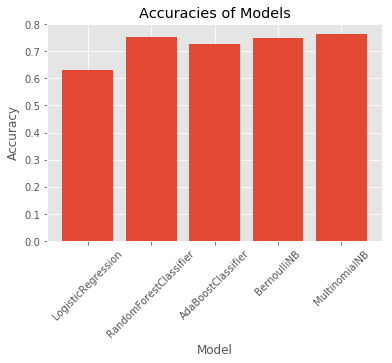

In [66]:
Index = [1,2,3,4,5]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')